# 以人臉檢測實現人臉貼圖

* **使用Yolo v3 Tiny實現人臉辨識**
* **針對貼圖進行影像前處理**
* **使用dlib偵測人臉特徵實現人臉貼圖**

<img src="https://github.com/j82887/Face-Detection/blob/master/13_Pig%20Face/Posting%20a%20Picture%20-%20Test.png?raw=true" align="left" alt="drawing" width="300"/>

## 使用Yolo v3 Tiny實現人臉辨識
* 使用OpenCV中Lib讀取Yolo v3 Tiny的cfg與weights
* 讀取name檔中的標籤名稱
* 定義繪出框的顏色RGB
* 定義人臉偵測的yolo_detect函數
    * 改變影像大小，以方便於後使用攝影機控制投射大小
    * 影像前處理
        * 正規化
        * 影像縮放置與輸出層的大小相同，即(416,416)
        * RB通道互換，需要改為RGB通道
    * 前向傳播後獲得輸出值，並使用For迴圈將輸出做處理：
        * 定義閥值將高置信度度的框留下
        * 存至（tx,ty, tw, th, confidence）變數
        * 轉為正常大小的（x, y, w, h, confidence）
        * 儲存高機率的標籤
    * 使用非最大抑制方法來將重疊的框做移除，並儲存該框的index
    * 繪製框至影像上

In [1]:
import cv2
import numpy as np

net = cv2.dnn.readNetFromDarknet("yolov3-tiny.cfg","./test_yolov3-tiny_10000.weights")

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

classes = [line.strip() for line in open("cfg_mask/obj2.names")]

colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    
    img = cv2.resize(frame, None, fx=1.0, fy=1.0)
    height, width, channels = img.shape 
    
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.2:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.6)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 8)
            cv2.putText(img, label, (x, y -10), font, 2, color, 4)
    return img

## 測試Yolo_detect函數
* 讀取測試影像
* 測試函數
* 該影響轉為RGB，並顯示該影像

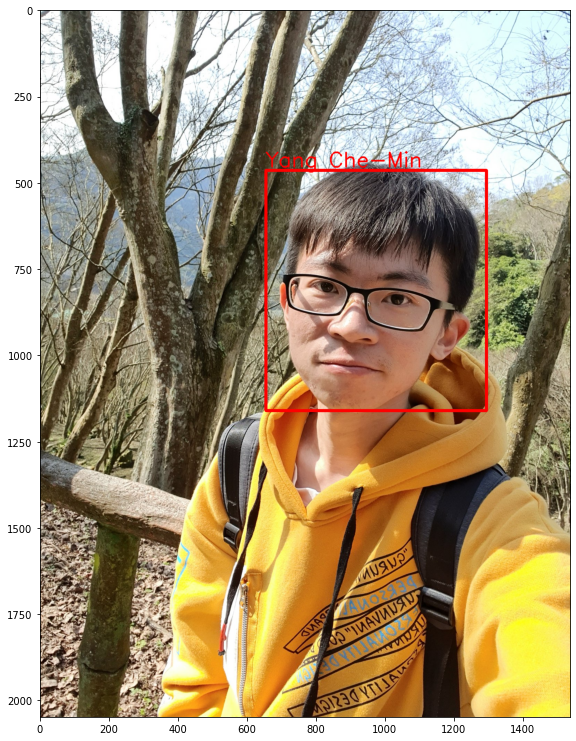

In [2]:
import matplotlib.pyplot as plt

img = cv2.imread("Face_test.jpeg")
im = yolo_detect(img)
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,13))
plt.imshow(img_rgb)

## 針對貼圖進行影像前處理
* 建立放置背景為黑的豬鼻子之空陣列
* 將空陣列放入指定像素：
    * 將背景為白色之外的區域之像素存原來豬鼻子的像素
    * 將背景為白色的區域之像素存黑色

豬鼻子維度大小為： (225, 225, 3)


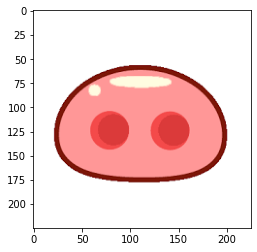

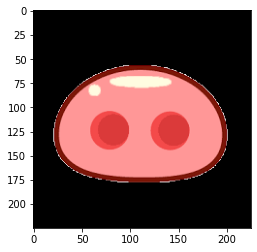

True

In [9]:
import cv2
import numpy as np

# 讀取豬鼻子影像，並轉為RGB
pig = cv2.imread('pig.png')
pig = cv2.cvtColor(pig, cv2.COLOR_BGR2RGB)

# 打印豬鼻子維度，分割RGB通道
print("豬鼻子維度大小為：", pig.shape)
r,g,b = cv2.split(pig)

# 顯示豬鼻子影像
plt.imshow(pig)
plt.show()

# 建立放置背景為黑的豬鼻子之空陣列，並指定此陣列只存放整數
black_pig = np.empty(pig.shape)
black_pig = black_pig.astype(int)

# 跑寬與高的多巢迴圈，設立條件式：將背景為白色之外的區域之像素存原來豬鼻子的像素;反之，背景為白色的區域之像素存黑色
for h in range(black_pig.shape[0]):
    for w in range(black_pig.shape[1]):
        if ((b[h][w]) == 255)&((g[h][w]) == 255)&((r[h][w]) == 255):
            black_pig[h][w][0]=0
            black_pig[h][w][1]=0
            black_pig[h][w][2]=0
        else:
            black_pig[h][w][0]=pig[h][w][0]
            black_pig[h][w][1]=pig[h][w][1]
            black_pig[h][w][2]=pig[h][w][2]

# 顯示背景為黑的豬鼻子影像
plt.imshow(black_pig)
plt.show()

# 儲存背景為黑的豬鼻子影像
cv2.imwrite("black_pig.jpg",black_pig)

## 使用dlib偵測人臉特徵實現人臉貼圖
* 使用鼻子左右特徵來計算歐式距離，控制豬鼻子放置大小及位置
* 結合兩張影像區域，利用二值化方式

![](https://miro.medium.com/max/3840/1*stAhFcyYdNqGvV26xMdE7w.png)

人臉之位置 rectangles[[(683, 732) (1128, 1178)]]


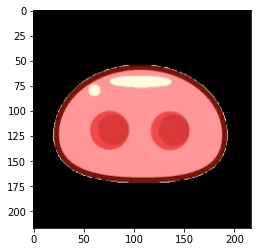

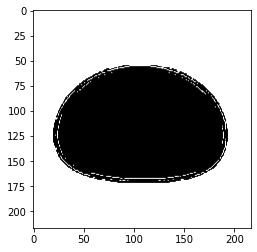

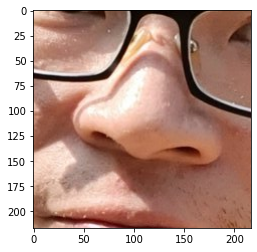

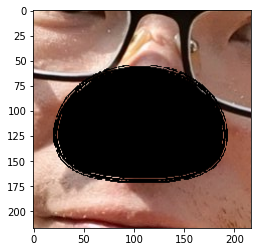

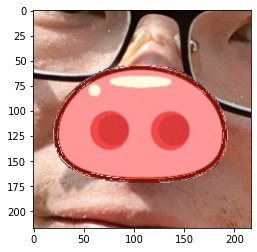

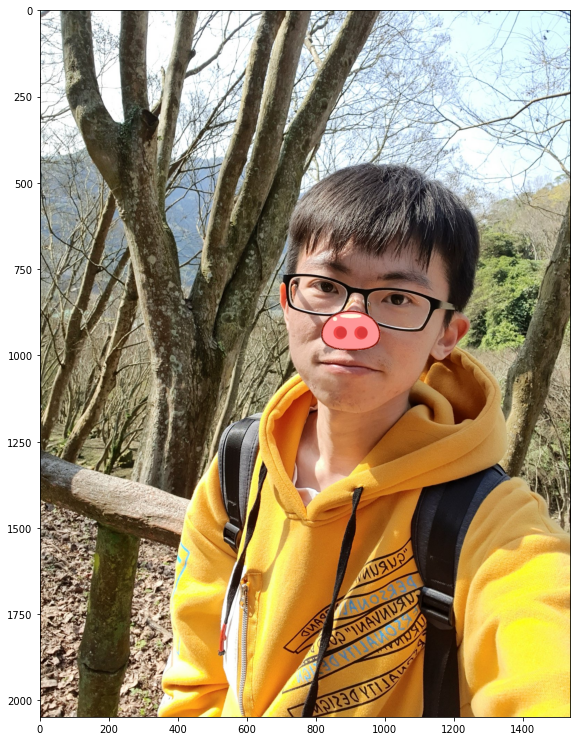

In [10]:
import dlib
from math import hypot

# 讀取人臉辨識模型
detector = dlib.get_frontal_face_detector()

# 讀取人臉辨識之特徵模型
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 讀取影像（人臉與豬鼻子）
img = cv2.imread("Face_test.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
black_pig = cv2.imread('black_pig.jpg')

# 影像代入人臉辨識模型，需帶入RGB影像
face = detector(img)
print("人臉之位置", face)

# 轉成灰階影像
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 將多個人臉帶入迴圈中
for face in face:
    
    # 使用灰階影像偵測臉特徵的詳細位置
    landmarks = predictor(img_gray, face)
    
    # 獲得鼻子上方、中間、左邊及右邊的座標位置
    top_nose = (landmarks.part(29).x, landmarks.part(29).y)
    center_nose = (landmarks.part(30).x, landmarks.part(30).y)
    left_nose = (landmarks.part(31).x, landmarks.part(31).y)
    right_nose = (landmarks.part(35).x, landmarks.part(35).y)
    
    # 繪製圓至原始影像上
    #cv2.circle(img, top_nose, 10, (255,0,0), -1)
    #cv2.circle(img, left_nose, 10, (255,0,0), -1)
    #cv2.circle(img, right_nose, 10, (255,0,0), -1)
    
    # 計算鼻子寬(鼻子左邊至右邊的歐式距離)，高度則是一樣（原因鼻子大小高寬相同），並定於2.2倍
    nose_width = int(hypot(left_nose[0]-right_nose[0],left_nose[1]-right_nose[1])*2.2)
    nose_height = int(nose_width)
    
    # 鼻子左上與右下的位置，即正方形
    top_left = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
    bottom_right = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
    
    # 改變豬鼻子大小，與我鼻子同寬高
    nose_pig = cv2.resize(black_pig, (nose_width, nose_height))
    plt.imshow(nose_pig)
    plt.show()
    
    # 豬鼻子變成灰階, 使用閥值變成二值化
    nose_pig_gray = cv2.cvtColor(nose_pig, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(nose_pig_gray, 25, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(nose_mask, cmap ='gray')
    plt.show()
    
    # 豬鼻子預放入的區域大小之鼻子部分
    nose_area = img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width]
    plt.imshow(nose_area)
    plt.show()
    
    # 每個畫素值進行二進位制“&”操作，1&1=1，1&0=0，0&1=0，0&0=0，
    nose_area_no_nose = cv2.bitwise_and(nose_area,nose_area,mask=nose_mask)
    plt.imshow(nose_area_no_nose)
    plt.show()
    
    # 將豬鼻子與真鼻子外影像結合的矩形
    final_nose = cv2.add(nose_area_no_nose, nose_pig)
    plt.imshow(final_nose)
    plt.show()
    
    # 將矩形放入原來影像之矩形
    img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width] = final_nose
    plt.figure(figsize=(15,13))
    plt.imshow(img)
    plt.show()
    cv2.imwrite("Posting a Picture - Test.png",cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 測試face_post_pig函數
* 使用攝像頭或影片測試該函數

In [2]:
def face_post_pig(img, black_pig, detector, predictor):
    
    img = cv2.resize(img, None, fx=0.8, fy=0.8)
    face = detector(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for face in face:
    
        landmarks = predictor(img_gray, face)
    
        top_nose = (landmarks.part(29).x, landmarks.part(29).y)
        center_nose = (landmarks.part(30).x, landmarks.part(30).y)
        left_nose = (landmarks.part(31).x, landmarks.part(31).y)
        right_nose = (landmarks.part(35).x, landmarks.part(35).y)
        
        nose_width = int(hypot(left_nose[0]-right_nose[0],left_nose[1]-right_nose[1])*2.2)
        nose_height = int(nose_width)
    
        top_left = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
        bottom_right = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
        
        nose_pig = cv2.resize(black_pig, (nose_width, nose_height))
        nose_pig_gray = cv2.cvtColor(nose_pig, cv2.COLOR_BGR2GRAY)
        _, nose_mask = cv2.threshold(nose_pig_gray, 25, 255, cv2.THRESH_BINARY_INV)
        
        nose_area = img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width]
        nose_area_no_nose = cv2.bitwise_and(nose_area,nose_area,mask=nose_mask)
        final_nose = cv2.add(nose_area_no_nose, nose_pig)
        img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width] = final_nose

    return img

In [3]:
import cv2
import dlib
from math import hypot

black_pig = cv2.imread('black_pig.jpg')
black_pig = cv2.cvtColor(black_pig, cv2.COLOR_BGR2RGB)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 使用攝影頭
VIDEO_IN = cv2.VideoCapture(0)

# 使用影片
#VIDEO_IN = cv2.VideoCapture("Video3.mp4") 

while True:
    hasFrame, frame = VIDEO_IN.read()

    img = face_post_pig(frame, black_pig, detector, predictor)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()